In [1]:
import math
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
class StockARIMA:
    def __init__(self, csv_path):
        self.df = self.read_csv(csv_path)
        self.log_df = np.log(self.df)
        self.decomposition = seasonal_decompose(self.log_df, model='multiplicative', period = 30)
        self.train, self.test = self.log_df[:int(len(self.log_df)*0.9)], self.log_df[int(len(self.log_df)*0.9):]

    def run(self):
        self.plot_rolling_statistics()
        self.augmented_dickey_fuller_test(self.log_df)
        self.plot_seasonal_decompose()
        self.residual_check()
        self.show_train_test()
        self.find_arima_hyper()
        self.make_model()

    def read_csv(self, csv_path):
        df = pd.read_csv(csv_path, index_col='Date', parse_dates=True)
        df = df['Close'].interpolate(method='time')
        df = df[~df.isna()]
        return df


    def plot_rolling_statistics(self, window=12):
        rolmean = self.log_df.rolling(window=window).mean()  # 이동평균 시계열
        rolstd = self.log_df.rolling(window=window).std()    # 이동표준편차 시계열

        plt.plot(self.log_df, color='blue',label='Original')    
        plt.plot(rolmean, color='red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)

    def augmented_dickey_fuller_test(self, df):
        dftest = adfuller(df, autolag='AIC')  
        
        print('Results of Dickey-Fuller Test:')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)' % key] = value
        print(dfoutput)


    def plot_seasonal_decompose(self):
        trend = self.decomposition.trend
        seasonal = self.decomposition.seasonal
        residual = self.decomposition.resid

        plt.subplot(411)
        plt.plot(self.log_df, label='Original')
        plt.legend(loc='best')
        plt.subplot(412)
        plt.plot(trend, label='Trend')
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality')
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(residual, label='Residuals')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

    
    def residual_check(self):
        residual = self.decomposition.resid.dropna()
        self.augmented_dickey_fuller_test(residual)


    def show_train_test(self):
        plt.figure(figsize=(10,6))
        plt.grid(True)
        plt.plot(self.log_df, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
        plt.plot(self.test, c='b', label='test dataset')
        plt.legend()
        plt.show()


    def find_arima_hyper(self):
        plot_acf(self.log_df)   # ACF : Autocorrelation 그래프 그리기
        plot_pacf(self.log_df)  # PACF : Partial Autocorrelation 그래프 그리기
        plt.show()

        diff_1 = self.log_df.diff(periods=1).iloc[1:]
        diff_1.plot(title='Difference 1st')
        self.augmented_dickey_fuller_test(diff_1)
        plt.show()

        diff_2 = diff_1.diff(periods=1).iloc[1:]
        diff_2.plot(title='Difference 2nd')
        self.augmented_dickey_fuller_test(diff_2)
        plt.show()

    
    def make_model(self):
        index_ = self.train.index
        self.train.index = pd.DatetimeIndex(self.train.index).to_period('D')

        model = ARIMA(self.train, order=(1, 1, 0))  
        fitted_m = model.fit(disp=-1)  
        print(fitted_m.summary())
        self.train.index = index_

        fc, se, conf = fitted_m.forecast(len(self.test), alpha=0.05)  # 95% conf

        fc_series = pd.Series(fc, index=self.test.index)   # 예측결과
        lower_series = pd.Series(conf[:, 0], index=self.test.index)  # 예측결과의 하한 바운드
        upper_series = pd.Series(conf[:, 1], index=self.test.index)  # 예측결과의 상한 바운드

        plt.figure(figsize=(10,5), dpi=100)
        plt.plot(self.train, label='training')
        plt.plot(self.test, c='b', label='actual price')
        plt.plot(fc_series, c='r',label='predicted price')
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
        plt.legend()
        plt.show()

        mse = mean_squared_error(np.exp(self.test), np.exp(fc))
        print('MSE: ', mse)

        mae = mean_absolute_error(np.exp(self.test), np.exp(fc))
        print('MAE: ', mae)

        rmse = math.sqrt(mean_squared_error(np.exp(self.test), np.exp(fc)))
        print('RMSE: ', rmse)

        mape = np.mean(np.abs(np.exp(fc) - np.exp(self.test))/np.abs(np.exp(self.test)))
        print('MAPE: {:.2f}%'.format(mape*100))


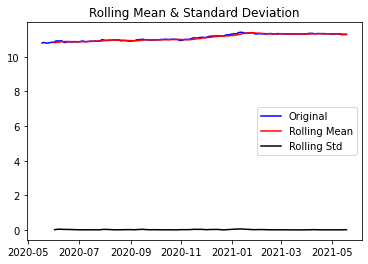

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


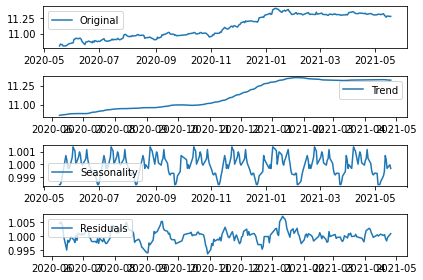

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


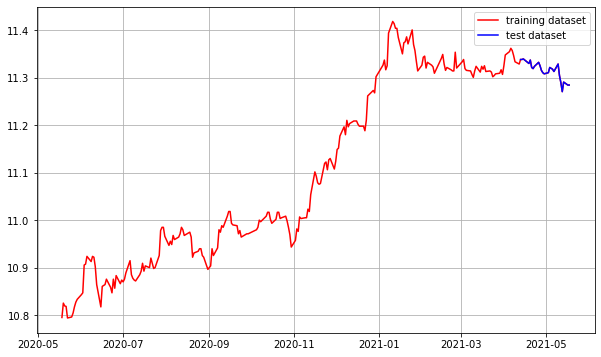

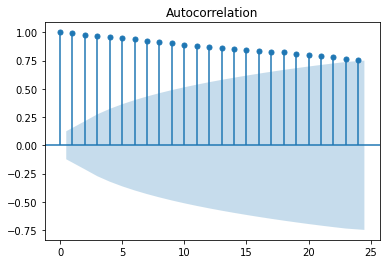

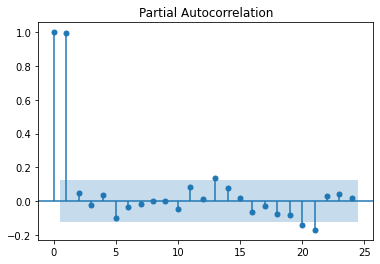

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


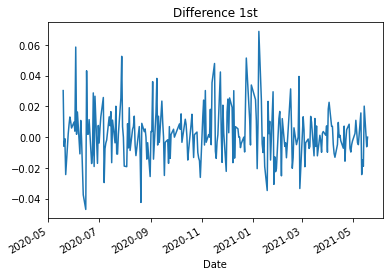

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


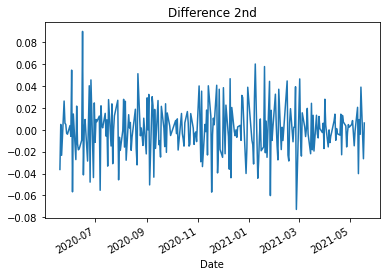

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 18 Nov 2021   AIC                          -1164.792
Time:                        12:08:15   BIC                          -1154.557
Sample:                    05-19-2020   HQIC                         -1160.661
                         - 04-12-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

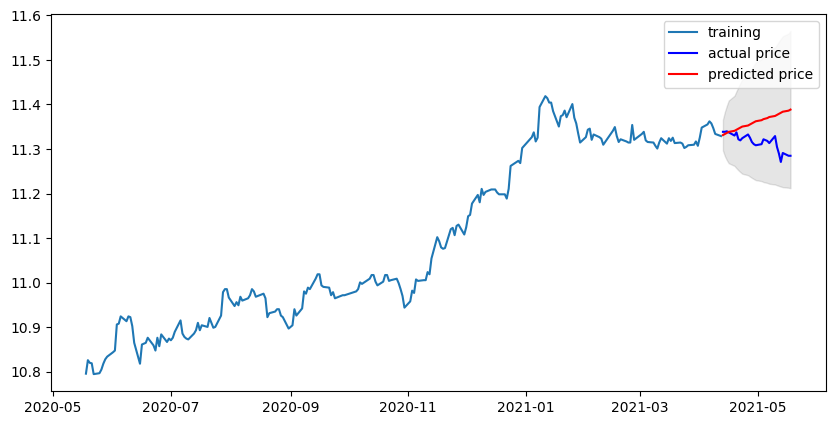

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


In [3]:
path = 'stock_prediction/data/005930.KS.csv'
samsung = StockARIMA(path)
samsung.run()

STEP 7 : 다른 주식 종목 예측해 보기

    관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기



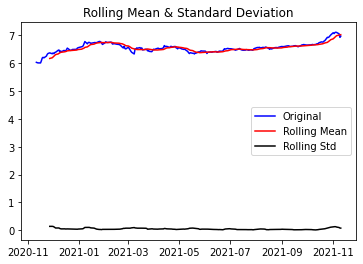

Results of Dickey-Fuller Test:
Test Statistic                  -2.132496
p-value                          0.231650
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


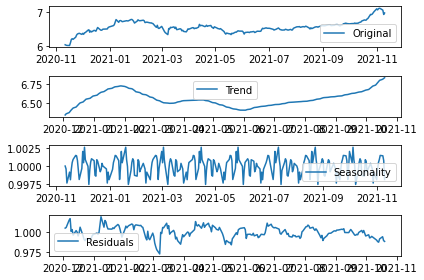

Results of Dickey-Fuller Test:
Test Statistic                  -5.206150
p-value                          0.000009
#Lags Used                       9.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


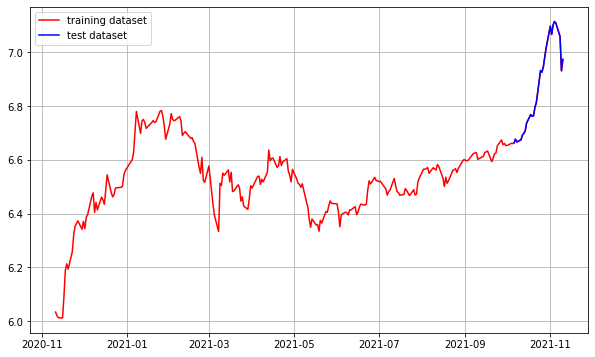

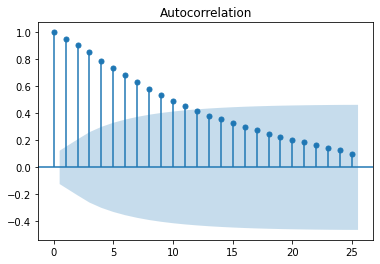

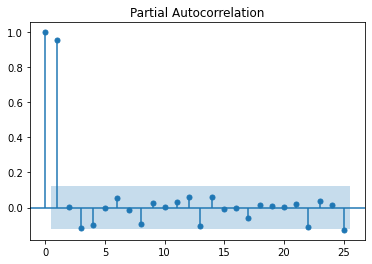

Results of Dickey-Fuller Test:
Test Statistic                -1.630466e+01
p-value                        3.240448e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


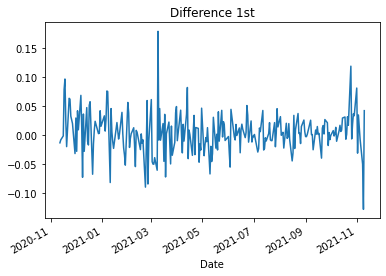

Results of Dickey-Fuller Test:
Test Statistic                -6.312671e+00
p-value                        3.206095e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


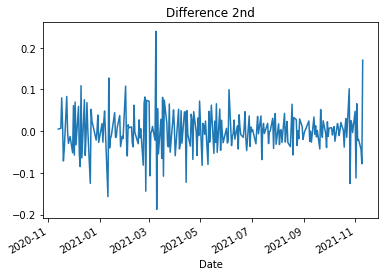

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 442.585
Method:                       css-mle   S.D. of innovations              0.034
Date:                Thu, 18 Nov 2021   AIC                           -879.170
Time:                        12:08:18   BIC                           -868.922
Sample:                    11-12-2020   HQIC                          -875.034
                         - 10-05-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0028      0.002      1.309      0.191      -0.001       0.007
ar.L1.D.Close    -0.0588      0.066     -0.885      0.376      -0.189       0.071
                                    Root

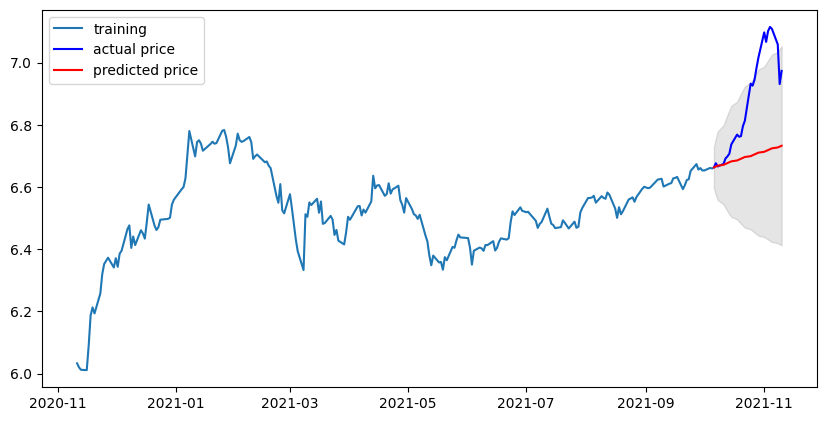

MSE:  47892.812983420285
MAE:  166.51054025590082
RMSE:  218.8442665079903
MAPE: 15.16%


In [4]:
path = 'TSLA.csv'
tesla = StockARIMA(path)
tesla.run()

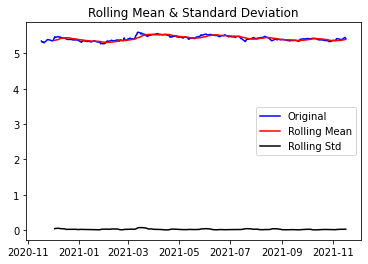

Results of Dickey-Fuller Test:
Test Statistic                  -2.718929
p-value                          0.070820
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


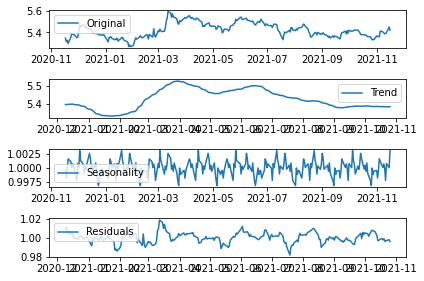

Results of Dickey-Fuller Test:
Test Statistic                -5.890931e+00
p-value                        2.925698e-07
#Lags Used                     5.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


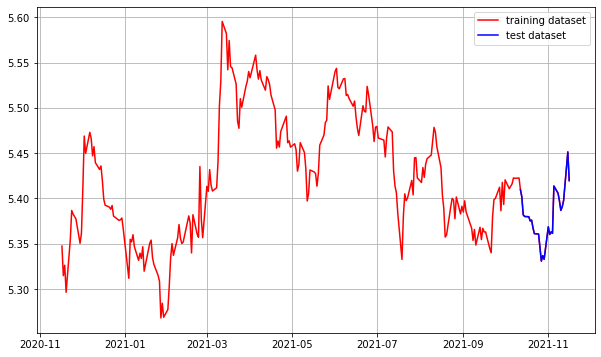

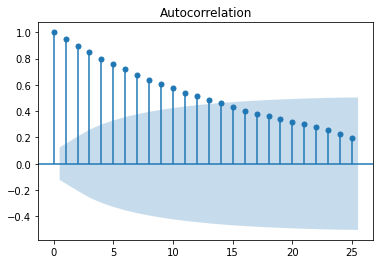

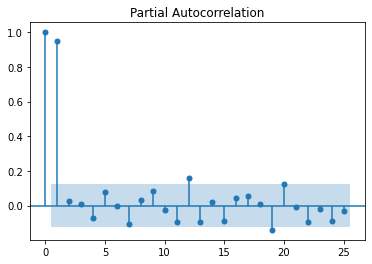

Results of Dickey-Fuller Test:
Test Statistic                -1.700976e+01
p-value                        8.608424e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


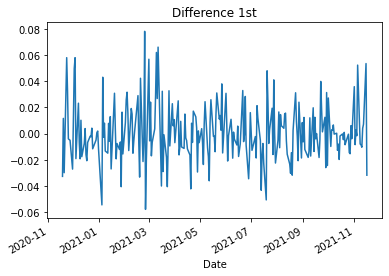

Results of Dickey-Fuller Test:
Test Statistic                -6.631226e+00
p-value                        5.708399e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


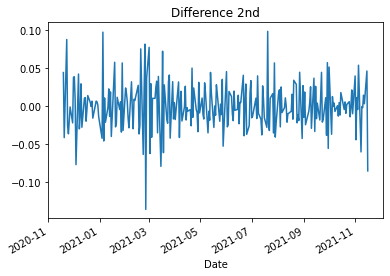

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 539.191
Method:                       css-mle   S.D. of innovations              0.022
Date:                Thu, 18 Nov 2021   AIC                          -1072.382
Time:                        12:08:20   BIC                          -1062.134
Sample:                    11-18-2020   HQIC                         -1068.246
                         - 10-11-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.250      0.803      -0.002       0.003
ar.L1.D.Close    -0.0675      0.067     -1.012      0.311      -0.198       0.063
                                    Root

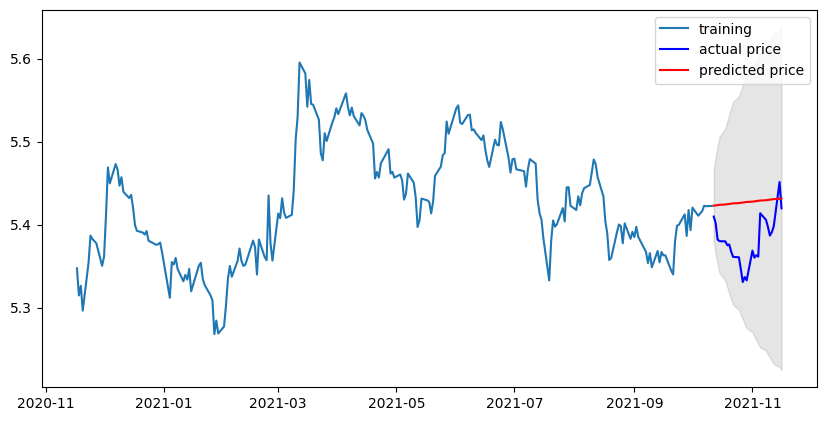

MSE:  147.2478509764839
MAE:  10.94735933139977
RMSE:  12.134572550217165
MAPE: 5.11%


In [5]:
path = 'BA.csv'
boeing = StockARIMA(path)
boeing.run()

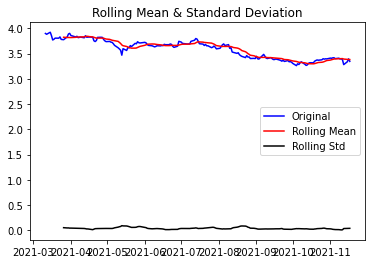

Results of Dickey-Fuller Test:
Test Statistic                  -1.330670
p-value                          0.615027
#Lags Used                       1.000000
Number of Observations Used    174.000000
Critical Value (1%)             -3.468502
Critical Value (5%)             -2.878298
Critical Value (10%)            -2.575704
dtype: float64


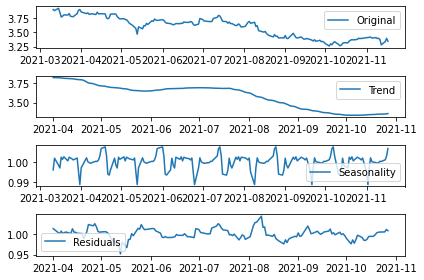

Results of Dickey-Fuller Test:
Test Statistic                  -5.525570
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64


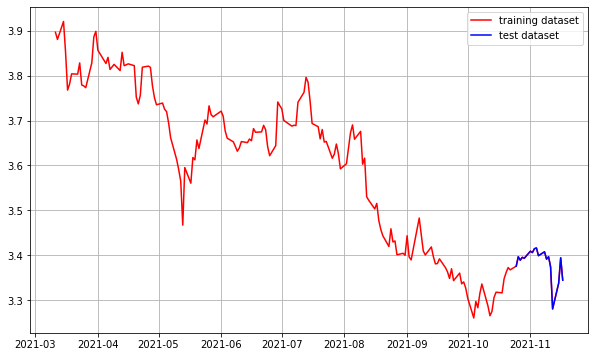

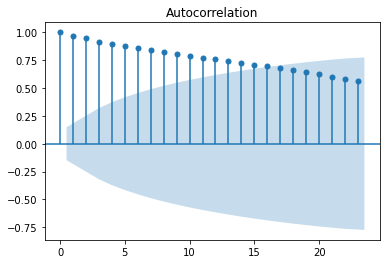

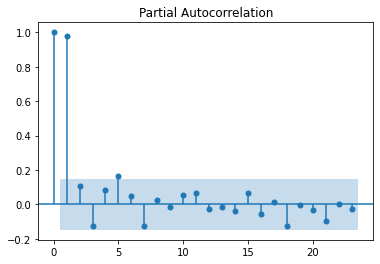

Results of Dickey-Fuller Test:
Test Statistic                -1.440680e+01
p-value                        8.331305e-27
#Lags Used                     0.000000e+00
Number of Observations Used    1.740000e+02
Critical Value (1%)           -3.468502e+00
Critical Value (5%)           -2.878298e+00
Critical Value (10%)          -2.575704e+00
dtype: float64


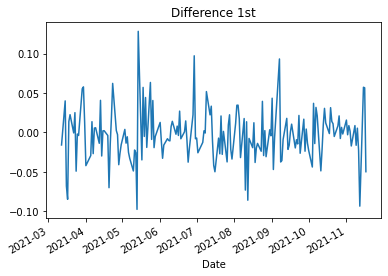

Results of Dickey-Fuller Test:
Test Statistic                -8.060815e+00
p-value                        1.644920e-12
#Lags Used                     7.000000e+00
Number of Observations Used    1.660000e+02
Critical Value (1%)           -3.470370e+00
Critical Value (5%)           -2.879114e+00
Critical Value (10%)          -2.576139e+00
dtype: float64


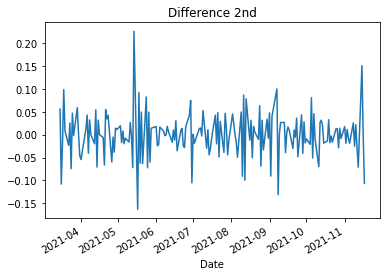

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  157
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 313.882
Method:                       css-mle   S.D. of innovations              0.033
Date:                Thu, 18 Nov 2021   AIC                           -621.764
Time:                        12:08:30   BIC                           -612.595
Sample:                    03-12-2021   HQIC                          -618.040
                         - 10-22-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0034      0.002     -1.401      0.161      -0.008       0.001
ar.L1.D.Close    -0.0891      0.079     -1.125      0.261      -0.245       0.066
                                    Root

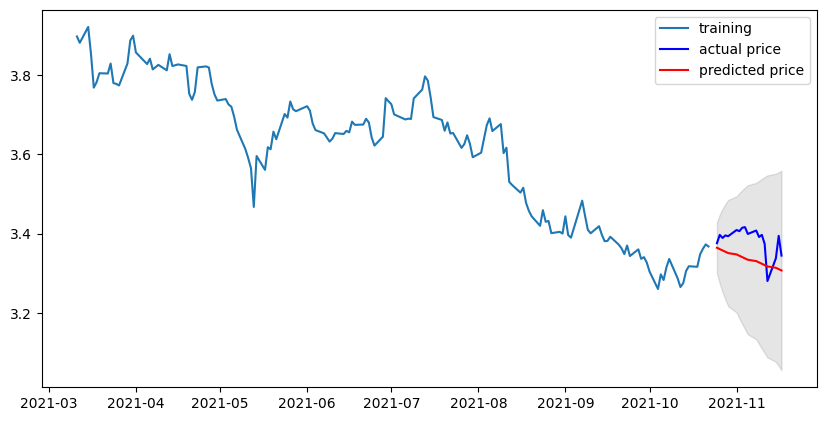

MSE:  2.698624237885012
MAE:  1.5293336436440559
RMSE:  1.6427489880943502
MAPE: 5.15%


In [6]:
path = 'CPNG.csv'
boeing = StockARIMA(path)
boeing.run()